In [3]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset
from torch.utils.data._utils.collate import default_collate

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from dataloading import repeat_channels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])
transform_eNetV2S = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [6]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.0  # overlap between consecutive windows

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform)

# split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/94 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1225
Number of unique IDs = 1225


In [7]:
import timm

# EfficientNetV2-S -- 20M params
#model = timm.create_model('tf_efficientnetv2_s', pretrained=True)

# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True)

# replace classifier layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # output one value
    #nn.ReLU(),
    #nn.Linear(640, 1),
    #nn.Sigmoid()
)

#summary(model.to('cpu'), (3, 224, 224))

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.BCEWithLogitsLoss()  #os_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 12
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=(len(train_loader.dataset) * num_epochs) // (train_loader.batch_size * 3),
                                        T_mult=1, verbose=False)

num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

In [9]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import precision_score, f1_score, cohen_kappa_score
import numpy as michayel


def safe_cohen_kappa_score(rater1, rater2):
    # Check for perfect agreement
    if michayel.array_equal(rater1, rater2):
        return 1.0

    # Check for no variation
    if michayel.unique(rater1).size == 1 and michayel.unique(rater2).size == 1:
        # Handle this case appropriately, maybe return NaN or a specific value
        return None

    # Calculate Cohen's Kappa
    try:
        return cohen_kappa_score(rater1, rater2)
    except ZeroDivisionError:
        # Handle division error
        return 0.0

def compute_metrics(predicted_probs, reference, threshold=0.5):
    """
    Compute the accuracy and f1 score for binary classification.

    @param predicted_logits: float32 tensor of shape (batch size, 1) representing raw model outputs (logits).
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = predicted_probs > threshold

    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_labels_np = predicted_labels.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision = precision_score(reference_np, predicted_labels_np, zero_division=0)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)
    kappa = safe_cohen_kappa_score(reference_np, predicted_labels_np)

    return precision, f1, kappa


def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []
    f1s_test = []
    f1s_train = []
    kappa_test = []
    kappa_train = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())

                losses.append(loss.item())

        model.eval()
        # evaluate on test set
        accuracies_test = []
        f1_test = []
        with tqdm(test_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1, kappa = compute_metrics(prediction, y_batch)
                    accuracies_test.append(acc)
                    f1_test.append(f1)
                    kappa_test.append(kappa)

        f1s_test.append(michayel.mean(f1_test))

        # evaluate on train set
        accuracies_train = []
        f1_train = []
        with tqdm(train_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1, kappa = compute_metrics(prediction, y_batch)
                    accuracies_train.append(acc)
                    f1_train.append(f1)
                    kappa_train.append(kappa)

        f1s_train.append(michayel.mean(f1_train))

        print(
            f"Epoch {epoch} | Train accuracy: {torch.tensor(accuracies_train).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_train).mean().item():.5f}, "
            f"kappa: {torch.tensor(kappa_train).mean().item():.5f}\n"
            f"           Test accuracy: {torch.tensor(accuracies_test).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_test).mean().item():.5f}, "
            f"kappa: {torch.tensor(kappa_test).mean().item():.5f}")

    plot_losses(losses)
    plot_f1(f1s_test, f1s_train)
    
    return f1s_train, f1s_test, kappa_train, kappa_test


def plot_losses(losses):
    plt.plot(losses, label='train')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()


def plot_f1(f1s_test, f1s_train):
    plt.plot(f1s_test, label='test')
    plt.plot(f1s_train, label='train')
    plt.title("f1")
    plt.ylabel('f1')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

training on device 'mps'


Epoch 0:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.64582, f1: 0.65432, kappa: 0.57041
           Test accuracy: 0.60296, f1: 0.61408, kappa: 0.51660


Epoch 1:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.92857, f1: 0.88814, kappa: 0.71481
           Test accuracy: 0.76220, f1: 0.59152, kappa: 0.51482


Epoch 2:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.95859, f1: 0.96204, kappa: 0.79396
           Test accuracy: 0.77282, f1: 0.64687, kappa: 0.53267


Epoch 3:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.97591, f1: 0.98499, kappa: 0.84057
           Test accuracy: 0.80853, f1: 0.67782, kappa: 0.55192


Epoch 4:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.97421, f1: 0.98303, kappa: 0.86818
           Test accuracy: 0.78233, f1: 0.69038, kappa: 0.56630


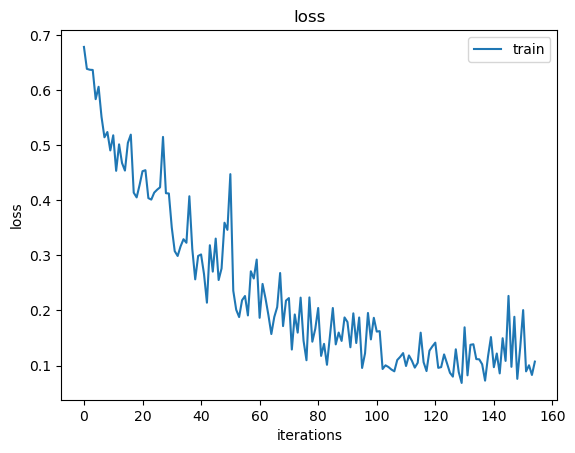

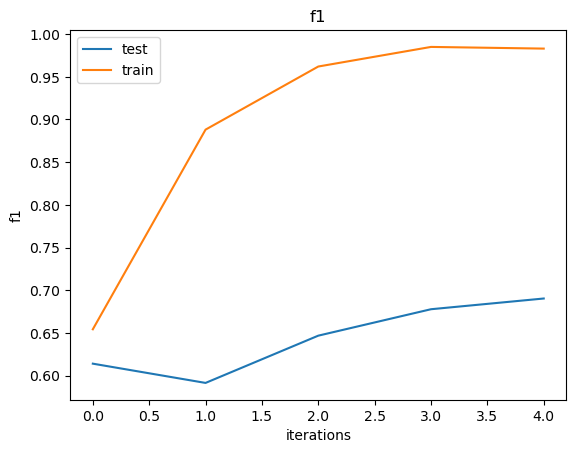

([0.6543246378558298,
  0.8881365735255679,
  0.9620396380882749,
  0.9849902818643457,
  0.983026919317242],
 [0.6140793438587556,
  0.59152183600713,
  0.6468671679197995,
  0.6778195488721804,
  0.6903769841269842],
 [0.6342857142857143,
  0.6363636363636364,
  0.6683937823834196,
  0.4545454545454546,
  0.7966101694915254,
  0.76,
  0.8745098039215686,
  0.4514285714285714,
  0.7876106194690266,
  0.34883720930232553,
  0.19999999999999996,
  0.7391304347826086,
  0.4545454545454546,
  0.4455445544554455,
  0.33333333333333337,
  0.2727272727272727,
  0.5636363636363637,
  0.7623762376237624,
  0.5180722891566265,
  0.8672199170124482,
  0.26436781609195403,
  0.7757009345794392,
  0.20661157024793386,
  0.76,
  0.1847133757961783,
  0.8614718614718615,
  0.8614718614718615,
  0.6756756756756757,
  0.33333333333333337,
  0.5652173913043479,
  0.625,
  0.7108433734939759,
  0.92,
  0.92,
  0.7647058823529411,
  1.0,
  0.8171428571428572,
  0.7647058823529411,
  1.0,
  0.796178343949

In [10]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=5)

Fold 0


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1843
Number of unique IDs = 1843


Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 551
Number of unique IDs = 551
training on device 'mps'


Epoch 0:   0%|          | 0/58 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.86950, f1: 0.80154, kappa: 0.75625
           Test accuracy: 0.75397, f1: 0.46354, kappa: 0.41910


Epoch 1:   0%|          | 0/58 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.96860, f1: 0.95915, kappa: 0.85274
           Test accuracy: 0.75463, f1: 0.47556, kappa: 0.39551


Epoch 2:   0%|          | 0/58 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.99037, f1: 0.99316, kappa: 0.89895
           Test accuracy: 0.71455, f1: 0.49979, kappa: 0.39472


Epoch 3:   0%|          | 0/58 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 0.99808, kappa: 0.92359
           Test accuracy: 0.70595, f1: 0.47483, kappa: 0.38859


Epoch 4:   0%|          | 0/58 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99899, kappa: 0.93860
           Test accuracy: 0.65787, f1: 0.44618, kappa: 0.37903


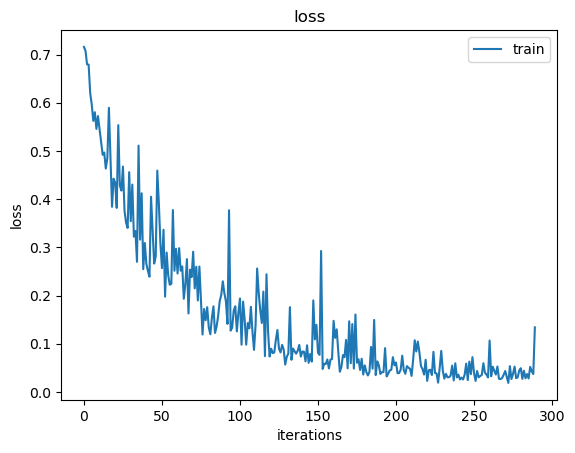

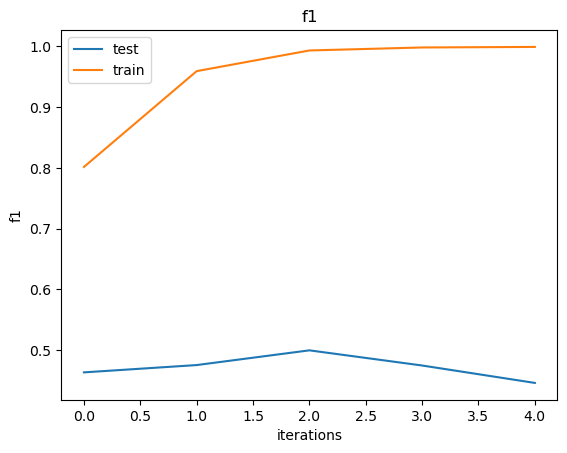

Fold 1


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1960
Number of unique IDs = 1960


Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 434
Number of unique IDs = 434
training on device 'mps'


Epoch 0:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.77500, f1: 0.82212, kappa: 0.77083
           Test accuracy: 0.68576, f1: 0.68647, kappa: 0.59585


Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.96235, f1: 0.96817, kappa: 0.86507
           Test accuracy: 0.77387, f1: 0.72016, kappa: 0.61938


Epoch 2:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.98157, f1: 0.98007, kappa: 0.90845
           Test accuracy: 0.72743, f1: 0.63659, kappa: 0.60047


Epoch 3:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.98387, f1: 0.98240, kappa: 0.93090
           Test accuracy: 0.75635, f1: 0.67508, kappa: 0.60089


Epoch 4:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99853, kappa: 0.94436
           Test accuracy: 0.77503, f1: 0.72336, kappa: 0.60951


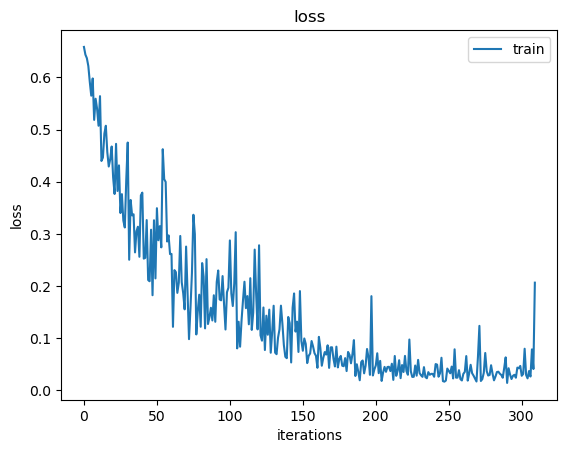

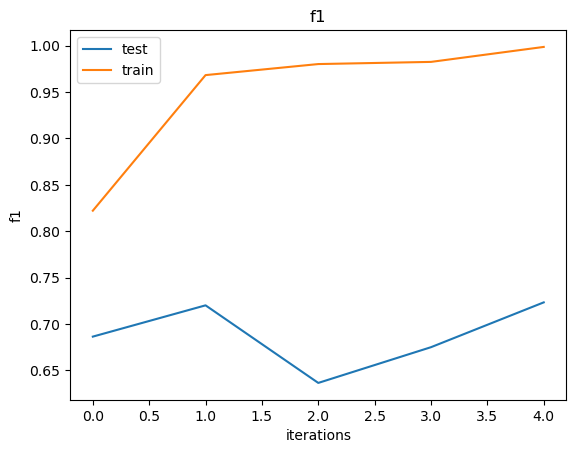

Fold 2


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1889
Number of unique IDs = 1889


Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 505
Number of unique IDs = 505
training on device 'mps'


Epoch 0:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.83215, f1: 0.82792, kappa: 0.80222
           Test accuracy: 0.65114, f1: 0.68191, kappa: 0.58096


Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.96152, f1: 0.96093, kappa: 0.88707
           Test accuracy: 0.64510, f1: 0.67354, kappa: 0.57632


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.99432, f1: 0.99599, kappa: 0.92289
           Test accuracy: 0.67251, f1: 0.70613, kappa: 0.58781


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.98333, f1: 0.98222, kappa: 0.94181
           Test accuracy: 0.66694, f1: 0.68272, kappa: 0.58672


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99848, kappa: 0.95308
           Test accuracy: 0.61549, f1: 0.61740, kappa: 0.57321


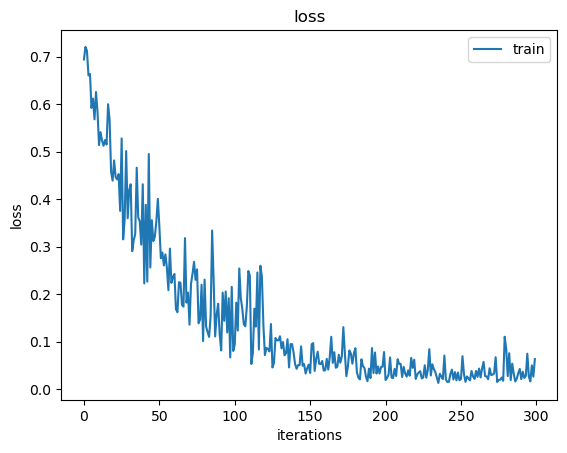

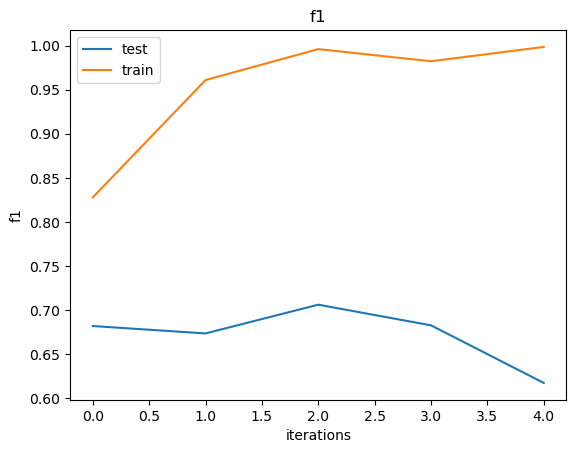

Fold 3


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1921
Number of unique IDs = 1921


Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 473
Number of unique IDs = 473
training on device 'mps'


Epoch 0:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.82043, f1: 0.81552, kappa: 0.78176
           Test accuracy: 0.64984, f1: 0.60348, kappa: 0.52398


Epoch 1:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.96289, f1: 0.95520, kappa: 0.87289
           Test accuracy: 0.74913, f1: 0.56764, kappa: 0.51088


Epoch 2:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.97546, f1: 0.97504, kappa: 0.91150
           Test accuracy: 0.67651, f1: 0.54970, kappa: 0.49783


Epoch 3:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99178, f1: 0.99474, kappa: 0.93188
           Test accuracy: 0.65019, f1: 0.58796, kappa: 0.49993


Epoch 4:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99161, f1: 0.99442, kappa: 0.94405
           Test accuracy: 0.66056, f1: 0.59441, kappa: 0.50165


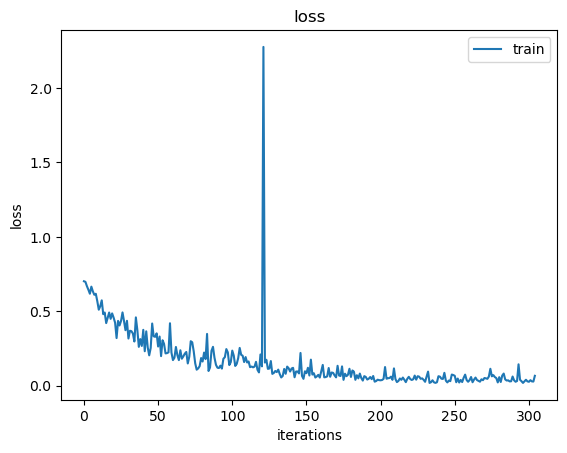

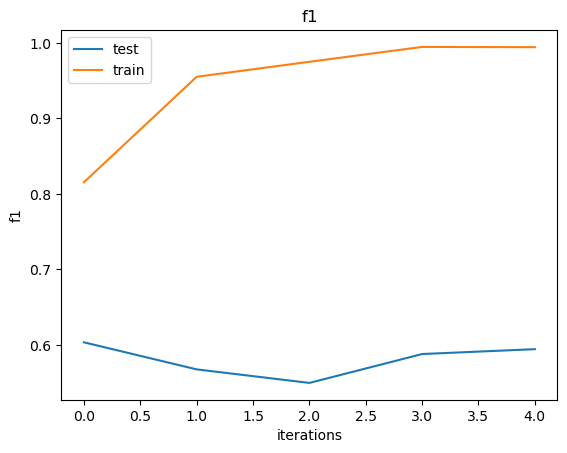

Fold 4


Processing dataset:   0%|          | 0/76 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1963
Number of unique IDs = 1963


Processing dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 431
Number of unique IDs = 431
training on device 'mps'


Epoch 0:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.85111, f1: 0.78166, kappa: 0.72480
           Test accuracy: 0.83503, f1: 0.68009, kappa: 0.62562


Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.95633, f1: 0.95222, kappa: 0.83283
           Test accuracy: 0.84833, f1: 0.77781, kappa: 0.67618


Epoch 2:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.99731, f1: 0.99709, kappa: 0.88722
           Test accuracy: 0.86281, f1: 0.78335, kappa: 0.69778


Epoch 3:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 0.99729, kappa: 0.91458
           Test accuracy: 0.84286, f1: 0.78812, kappa: 0.70962


Epoch 4:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99798, kappa: 0.93113
           Test accuracy: 0.75717, f1: 0.73649, kappa: 0.71874


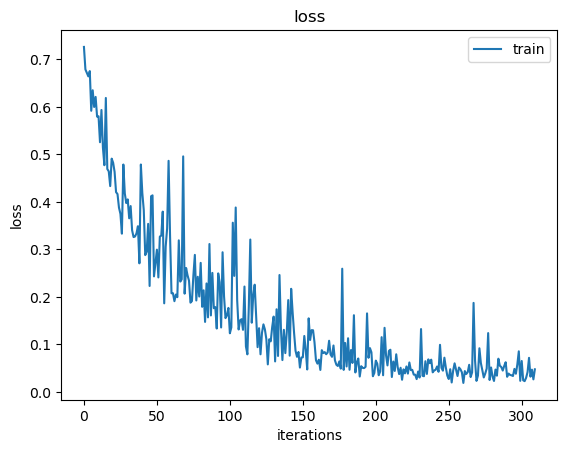

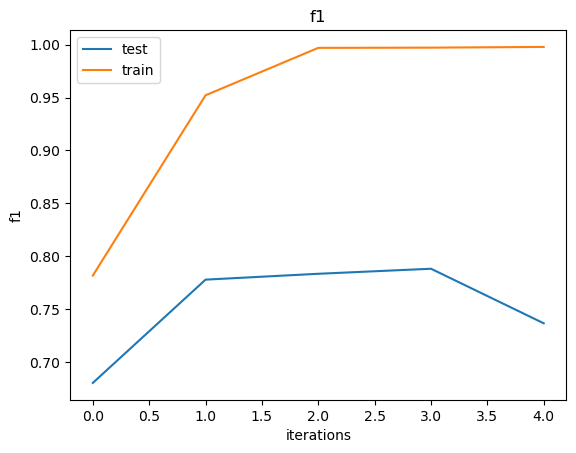

In [8]:
from sklearn.model_selection import KFold

DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.5  # overlap between consecutive windows

shot_count = 94
shot_indices = michayel.arange(94)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

f1s_tr = []
f1s_te = []
kappas_tr = []
kappas_te = []

for fold, (train_ids, val_ids) in enumerate(kf.split(shot_indices)):
    print(f"Fold {fold}\n")

    train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE,
                                       overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_ids)
    val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE,
                                     overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

    # Init the neural network
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 1),  # output one value
    )

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  #pos_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits

    num_epochs = 5
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # Run the training loop for defined number of epochs
    f1_tr, f1_te, kappa_tr, kappa_te = train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=5)
    f1s_tr.append(f1_tr)
    f1s_te.append(f1_te)
    kappas_tr.append(kappa_tr)
    kappas_te.append(kappa_te)
    
print(f"test f1: {michayel.mean(f1s_te)} ± {michayel.std(f1s_te)}")
print(f"test kappa: {michayel.mean(kappas_te)} ± {michayel.std(kappas_te)}")